# Build a DNN using the Keras Functional API




## Learning objectives

1. Review how to read in CSV file data using tf.data.
2. Specify input, hidden, and output layers in the DNN architecture.
3. Review and visualize the final DNN shape.
4. Train the model locally and visualize the loss curves.
5. Deploy and predict with the model using Cloud AI Platform. 


## Introduction

In this notebook, we will build a Keras DNN to predict the fare amount for NYC taxi cab rides.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/neural_network.ipynb).

In [1]:
## https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/deepdive2/art_and_science_of_ml/labs

In [2]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [4]:
!sudo apt-get install graphviz -y

In [5]:
import os, json, math
import numpy as np
import shutil
import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # SET TF ERROR LOG VERBOSITY

2025-01-19 15:29:00.838948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 15:29:06.012650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/lib/x86_64-linux-gnu/:/opt/conda/lib
2025-01-19 15:29:06.012881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local

TensorFlow version:  2.11.0


## Locating the CSV files

We will start with the CSV files that we wrote out in the other notebook. Just so you don't have to run the notebook, we saved a copy in ../data/toy_data

In [6]:
!ls -l ../data/toy_data/*.csv

-rw-r--r-- 1 jupyter jupyter 1111933 Jan 19 15:21 ../data/toy_data/taxi-traffic-test_toy.csv
-rw-r--r-- 1 jupyter jupyter 4772181 Jan 19 15:21 ../data/toy_data/taxi-traffic-train_toy.csv
-rw-r--r-- 1 jupyter jupyter 1038564 Jan 19 15:21 ../data/toy_data/taxi-traffic-valid_toy.csv


## Lab Task 1: Use tf.data to read the CSV files


First let's define our columns of data, which column we're predicting for, and the default values.

In [7]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

Next, let's define our features we want to use and our label(s) and then load in the dataset for training.

In [35]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
        # repeate():
        # When you call .repeat() on a TensorFlow dataset, it instructs TensorFlow to loop over the dataset indefinitely. 
        # Essentially, once the dataset reaches its end, it automatically starts over from the beginning, 
        #creating an endless stream of data. This is particularly useful for training models where you might want to 
        # iterate over the dataset multiple times until convergence.
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

## Lab Task 2: Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and then visualize it later on.

In [17]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # TODO 2
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    # tf.feature_column.numeric_column() represents real valued or numerical features.
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    }
    
    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dropoff_latitude (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None,)]           0           []                               
                                                                                                  
 passenger_count (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None,)]            0           []                               
                                                      

## Lab Task 3: Visualize the DNN

We can visualize the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

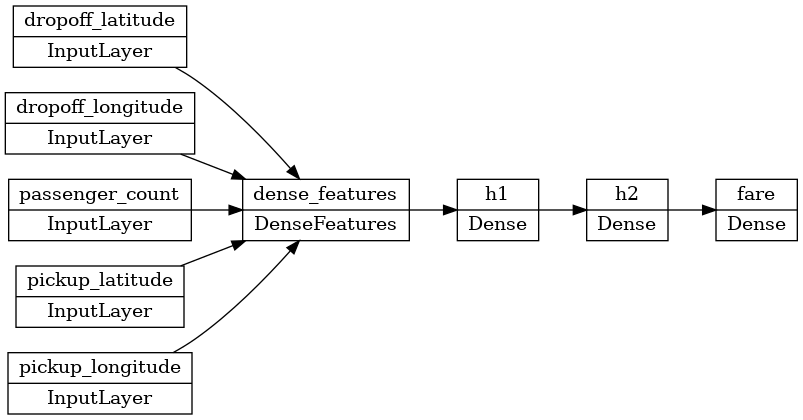

In [18]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [19]:
# The DenseFeatures layer is particularly designed to handle structured data, such as tabular data that includes 
# both numerical and categorical features. For structured data, the DenseFeatures layer preprocesses 
# and transforms the input features into a format that can be used by the rest of the neural network.

## Lab Task 4: Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).

Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [36]:
# This defines the batch size for training. The model will process 32 examples at a time during each training step.
TRAIN_BATCH_SIZE = 32 

# The training dataset contains 10,000 examples, and it's repeated 5 times, resulting in a total of 50,000 training examples. 
# The repetition allows the dataset to wrap around if the training process continues for multiple epochs.
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around

# This specifies the number of times to evaluate the model. 
# It effectively defines the number of epochs the model will train.
NUM_EVALS = 32  # how many times to evaluate

# This sets the number of examples to use for evaluation
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down
## this is just a sample -  if you would like your model to cover all the training data you need to specify nrows(trainds)

# This loads the training dataset from the specified file pattern, with a batch size of 32. 
# The ModeKeys.TRAIN indicates that this dataset is used for training.
trainds = load_dataset('../data/toy_data/taxi-traffic-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)

# This loads the evaluation dataset from the specified file pattern, with a batch size of 1000. 
# It then takes the first 10 batches (10,000 examples) for evaluation.
evalds = load_dataset('../data/toy_data/taxi-traffic-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

#This calculates the number of steps per epoch. The formula divides the total number of 
# training examples by the product of the batch size and the number of evaluations.
# steps_per_epoch: 50,000 // (32 * 32) = 50,000 // 1,024 = 48
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, # 32, meaning the model will go through the entire dataset 32 times.
                    steps_per_epoch=steps_per_epoch) # 48, meaning each epoch consists of 48 steps (steps mean batches).

# Steps_per_epoch:
# Since each epoch consists of 48 steps and each step processes 32 examples, 
# a total of 48 * 32 = 1,536 examples are processed in one epoch.
# However, the training dataset contains 50,000 examples (due to repetition). So, each epoch 
# covers 1,536 examples out of the 50,000. This means that it takes multiple epochs for the model 
# to see all examples in the training dataset.

Epoch 1/32
48/48 [==============================] - 1s 10ms/step - loss: 85.3229 - rmse: 8.8221 - mse: 85.3229 - val_loss: 88.7044 - val_rmse: 9.4017 - val_mse: 88.7044
Epoch 2/32
48/48 [==============================] - 0s 8ms/step - loss: 104.5788 - rmse: 9.7947 - mse: 104.5788 - val_loss: 85.5740 - val_rmse: 9.2406 - val_mse: 85.5740
Epoch 3/32
48/48 [==============================] - 0s 8ms/step - loss: 102.5947 - rmse: 9.5745 - mse: 102.5947 - val_loss: 86.0068 - val_rmse: 9.2548 - val_mse: 86.0068
Epoch 4/32
48/48 [==============================] - 0s 9ms/step - loss: 92.4704 - rmse: 9.1415 - mse: 92.4704 - val_loss: 85.8029 - val_rmse: 9.2435 - val_mse: 85.8029
Epoch 5/32
48/48 [==============================] - 0s 8ms/step - loss: 87.8946 - rmse: 8.8501 - mse: 87.8946 - val_loss: 88.9717 - val_rmse: 9.4177 - val_mse: 88.9717
Epoch 6/32
48/48 [==============================] - 0s 9ms/step - loss: 98.9877 - rmse: 9.4284 - mse: 98.9877 - val_loss: 86.8462 - val_rmse: 9.2970 - val_

### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

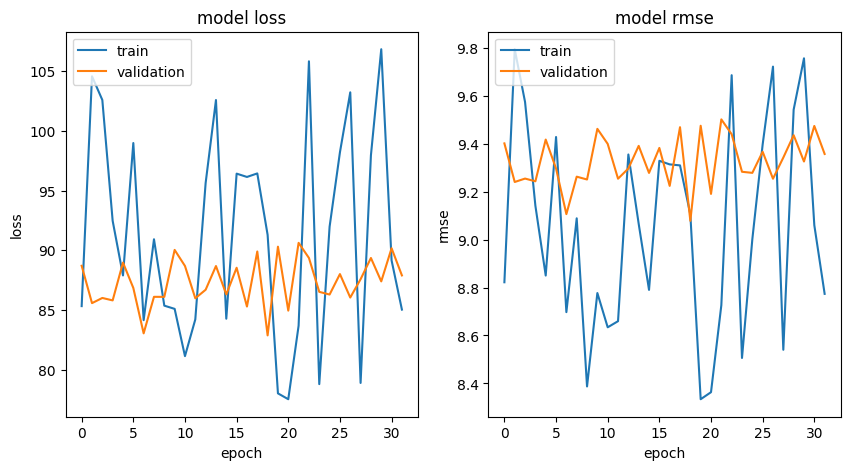

In [37]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Lab Task 5: Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [39]:
# TODO 5
model.predict({
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)


1/1 [==============================] - 0s 21ms/step


array([[-18.891926]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.